## План работ

1. Провести исследовательский анализ данных.
2. Сделать предобработку данных.
3. Подготовка признаков и целевого признака.
4. Провести обучение и выбрать наилучшую модель - CatBoostRegressor, LGBMRegressor, LinearRegression, DecisionTreeRegressor, RandomForestRegressor
5. Подготовить отчет.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#загрузка необходимых библиотек

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import time

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Исследовательский анализ данных

In [4]:
#выгрузка данных

bulk_time = pd.read_csv('/content/drive/My Drive/Collab file/data_bulk_time.csv')
data_gas = pd.read_csv('/content/drive/My Drive/Collab file/data_gas.csv')
data_arc = pd.read_csv('/content/drive/My Drive/Collab file/data_arc.csv')
data_bulk = pd.read_csv('/content/drive/My Drive/Collab file/data_bulk.csv')
data_temp = pd.read_csv('/content/drive/My Drive/Collab file/data_temp.csv')
data_wire = pd.read_csv('/content/drive/My Drive/Collab file/data_wire.csv')
data_wire_time = pd.read_csv('/content/drive/My Drive/Collab file/data_wire_time.csv')

In [5]:
# напишем общую функцию для распаковки данных

def open_data(data):
  display(data.head(5))
  print('-------------------------------')
  print('Общая информация')
  data.info()
  print('-------------------------------')
  print('Описание данных')
  display(data.describe())
  print('-------------------------------')
  print('Количество дубликатов')
  print(data.duplicated().sum())

## Данные об электродах

In [6]:
open_data(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


-------------------------------
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
-------------------------------
Описание данных


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


-------------------------------
Количество дубликатов
0


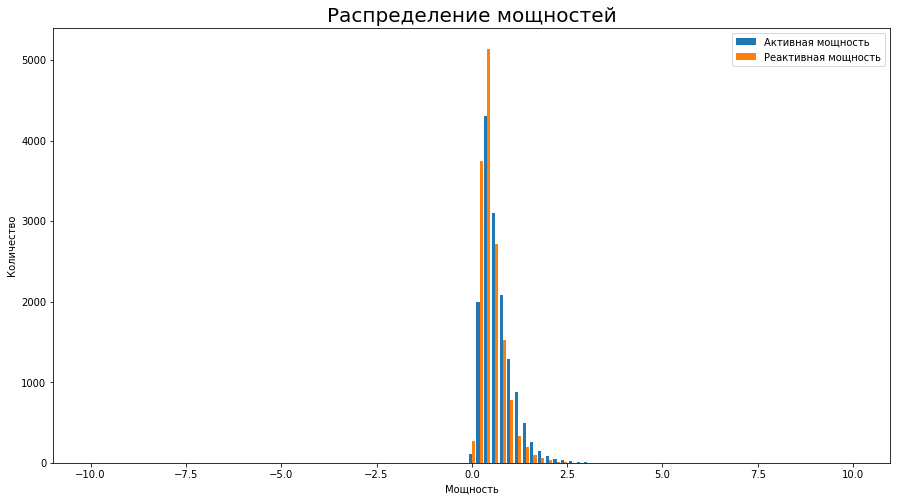

In [7]:
# посмотрим на распределение мощностей

x = data_arc['Активная мощность']
y = data_arc['Реактивная мощность']

bins = np.linspace(-10, 10, 100)
plt.figure(figsize=(15, 8))
plt.title(label='Распределение мощностей', fontsize=20)
plt.ylabel('Количество')
plt.xlabel('Мощность')

plt.hist([x, y], bins, label=['Активная мощность', 'Реактивная мощность'])
pyplot.legend(loc='upper right')
pyplot.show()

**Краткий вывод**

- Пропуски в таблице отсутствуют.
- Дубликатов в таблице нет.
- Из графика видно, что есть большой выброс по значению рекактивной мощности. Это может означать либо ошибку, либо большая часть энергии тратится в холостую. То есть за эту энергию сильно переплачивают (по всей видимости).

**План предобработки:**

- Привести данные к нужному типу.
- Добавить столбец с суммарным временем нагрева в секундах. Это позволит избавиться от столбцов "Начало нагрева дугой" и "Конец нагрева дугой"
- Проверить столбец "Активная мощность" на наличие отрицательных значений. По определению активная мощность не может быть отрицательной, в отличие от реактивной. При необходимости избавиться от этих строк, так как это явно будет ошибка. Хотя на графике можно заметить, что таких значений нет, однако проверить все равно стоит.
- Добавить столбец с полной мощностью. Это позволит избавиться от столбцов с активной и реактивной мощностями.
- Добавить столбец со значением работы.
- Заменить названия столбцов на английские.

## Данные о подаче сыпучих материалов (объём) 

In [8]:
open_data(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


-------------------------------
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
-------------------------------
Описание данных


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


-------------------------------
Количество дубликатов
0


**Краткий вывод**

- В таблице присутствует много пропусков.Это обусловлено, вероятно, технологическим процессом.
- Дубликатов в таблице нет.

**План предобработки:**

- Избавиться от пропусков, вместо них поставить 0, так как если есть пропуск, значит элемент не был введен.
- Создать столбец с с суммарным добавлением материалов для каждой партии.

## Данные о проволочных материалах (объём)

In [9]:
open_data(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-------------------------------
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
-------------------------------
Описание данных


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


-------------------------------
Количество дубликатов
0


**Краткий вывод**

- В таблице так же присутствует много пропусков.Это обусловлено, вероятно, технологическим процессом.
- Дубликатов в таблице нет.
- Интересно, что данных в таблице сыпучих материалов больше, то есть (предполагаю), что количество типов сыпучих материалов больше, чем проволочных, и не каждый тип необходим для каждой партии.

**План предобработки:**

- Избавиться от пропусков, вместо них поставить 0, так как если есть пропуск, значит элемент не был введен.
- Создать столбец с с суммарным добавлением материалов для каждой партии.

## Данные о продувке сплава газом

In [10]:
open_data(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


-------------------------------
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
-------------------------------
Описание данных


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


-------------------------------
Количество дубликатов
0


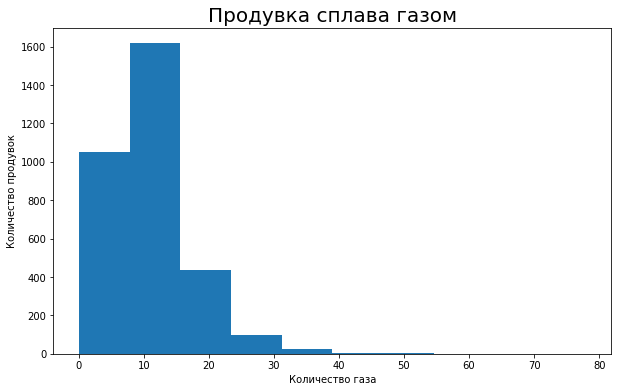

In [11]:
# посмотрим на распределение данных

plt.figure(figsize=(10, 6))

bins = np.linspace(-10, 10, 100)

plt.title(label='Продувка сплава газом', fontsize=20)
plt.ylabel('Количество продувок')
plt.xlabel('Количество газа')

plt.hist(data_gas['Газ 1'])

pyplot.show()

**Краткий вывод**

- Пропусков в таблице нет.
- Дубликатов в таблице нет.
- Есть небольшой хвост, начинающийся с 40.

**План предобработки:**

- Изменить название столбца на английский.
- Посмотреть на количество выбросов и, возможно, избавиться от них.

## Результаты измерения температуры

In [12]:
open_data(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


-------------------------------
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
-------------------------------
Описание данных


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


-------------------------------
Количество дубликатов
0


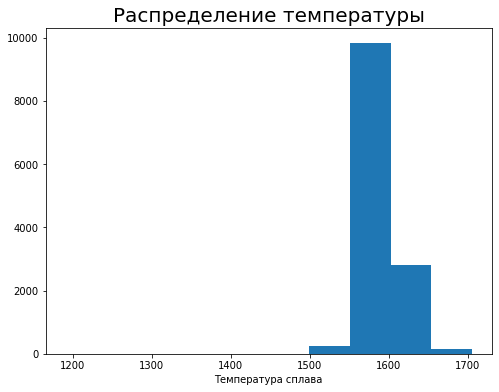

In [13]:
# посмотрим на распределение данных по температуре

plt.figure(figsize=(8, 6))

bins = np.linspace(-10, 10, 100)

plt.title(label='Распределение температуры', fontsize=20)
plt.xlabel('Температура сплава')

plt.hist(data_temp['Температура'])

pyplot.show()

**Краткий вывод**

- В столбце с температурой есть пропуски, возможно, они возникли по ошибке.
- Дубликатов нет.
- Интересно, что есть значения с температурой менее 1500 градусов (если я правильно поняла, то продуванием мы стремимся достичь как раз примерно 1500 градусов, не ниже), возможно, это ошибка.


**План предобработки:**

- Посмотреть на данные с пропусками, либо удалить их, либо на что-то заменить.
- Посмотреть на выбросы по температуре, также нужно решить, как с ними поступить.
- Проверить данные по столбцу с временем замера.
- Заменить названия столбцов на английские.


# Предобработка данных

## Данные об электродах

In [14]:
# приведем начало и конец нагрева к временному типу

data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format = '%Y-%m-%d %H:%M:%S')

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [15]:
# добавим столбец с временем нагрева, далее столбцы "начало" и "конец" уберем

data_arc['sum_heat_sec'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

data_arc.head(5)              

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,sum_heat_sec
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148


In [16]:
data_arc = data_arc.drop(columns=['Конец нагрева дугой', 'Начало нагрева дугой'], axis=1)

data_arc.head(5)

,key,Активная мощность,Реактивная мощность,sum_heat_sec
0,1,0.976059,0.687084,228
1,1,0.805607,0.520285,185
2,1,0.744363,0.498805,172
3,1,1.659363,1.062669,365
4,1,0.692755,0.414397,148


Text(0.5, 6.79999999999999, 'Время нагрева в секундах')

<Figure size 720x432 with 0 Axes>

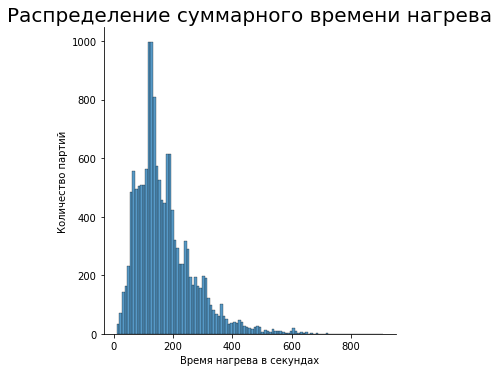

In [17]:
# посмотрим на график времени нагрева

plt.figure(figsize=(10, 6))
sns.displot(data_arc['sum_heat_sec'])

plt.title(label='Распределение суммарного времени нагрева', fontsize=20)
plt.ylabel('Количество партий')
plt.xlabel('Время нагрева в секундах')

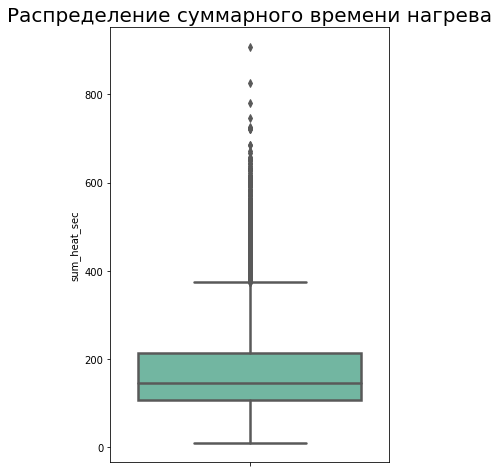

In [18]:
# также посмотрим на ящик с усами

plt.figure(figsize=(5,8))
plt.title(label='Распределение суммарного времени нагрева', fontsize=20)

sns.set_style('whitegrid')
sns.boxplot(y='sum_heat_sec', data=data_arc, orient="h", palette="Set2", linewidth=2.5)
   
plt.show()

Большинство данных лежит в районе 100-250 секунд, по всей видимости, это оптимальное время нагрева для многих партий.

In [19]:
# проверим, есть ли отрицательные значения в столбцах с мощностью

print('Количество отрицательных значений (активная мощность):', (data_arc['Активная мощность'] < 0).sum().sum())
print('Количество отрицательных значений (реактивная мощность):', (data_arc['Реактивная мощность'] < 0).sum().sum())

Количество отрицательных значений (активная мощность): 0
Количество отрицательных значений (реактивная мощность): 1


In [20]:
data_arc = data_arc.rename(columns = {'Реактивная мощность':'r_power'})
data_arc = data_arc.rename(columns = {'Активная мощность':'a_power'})

In [21]:
# удалим строчку с отрицательным значением реактивной мощности

data_arc = data_arc.drop(data_arc[data_arc.r_power < 0].index)

In [22]:
# создадим столбец с полной мощностью. Полная мощность равна корню из суммы квадратов активной и реактивной мощностей

data_arc['full_power'] = (data_arc['a_power'] ** 2 + data_arc['r_power'] ** 2) ** (1 / 2)

data_arc.head(5)

,key,a_power,r_power,sum_heat_sec,full_power
0,1,0.976059,0.687084,228,1.193639
1,1,0.805607,0.520285,185,0.959010
2,1,0.744363,0.498805,172,0.896038
3,1,1.659363,1.062669,365,1.970470
4,1,0.692755,0.414397,148,0.807239


In [23]:
# удалим столбцы со значениями активной и реактивной мощностей

data_arc = data_arc.drop(columns=['a_power', 'r_power'], axis=1)

data_arc.head(5)

,key,sum_heat_sec,full_power
0,1,228,1.193639
1,1,185,0.959010
2,1,172,0.896038
3,1,365,1.970470
4,1,148,0.807239


In [24]:
# сгруппируем таблицу по номеру партии и посчитаем сколько было итераций нагрева

agg_func_heat = {'sum_heat_sec': ['count', 'sum'], 'full_power': 'sum'}
data_arc_new = data_arc.groupby('key').agg(agg_func_heat).reset_index()
data_arc_new.columns = data_arc_new.columns.get_level_values(0)
data_arc_new = data_arc_new.set_axis(['key', 'count_heat', 'sum_heat_sec', 'full_power'], axis=1, inplace=False)
display(data_arc_new)

,key,count_heat,sum_heat_sec,full_power
0,1,5,1098,5.826395
1,2,4,811,3.649216
2,3,5,655,2.989534
3,4,4,741,3.814962
4,5,4,869,4.035758
...,...,...,...,...
3209,3237,5,909,4.844982
3210,3238,3,546,2.696542
3211,3239,8,1216,5.611883
3212,3240,5,839,3.891856


In [25]:
# добавим информацию о работе
# работа равна произведению полной мощности на время

data_arc_new['work'] = data_arc_new['sum_heat_sec'] * data_arc_new['full_power']

In [26]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3214 non-null   int64  
 1   count_heat    3214 non-null   int64  
 2   sum_heat_sec  3214 non-null   int64  
 3   full_power    3214 non-null   float64
 4   work          3214 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


**Краткий вывод**

Все пункты по плану предобработки были выполнены. В результате получили таблицу с сгруппированными по номеру партии данными.

## Данные о подаче сыпучих материалов (объём)

In [27]:
# заменим пропущенные значения на нули

data_bulk = data_bulk.fillna(0)

In [28]:
# удалим столбец Bulk 8 

data_bulk = data_bulk.drop('Bulk 8', axis=1)

In [29]:
# сделаем новый столбец с суммой всех добавлений для каждой партии

data_bulk['sum_bulk'] = data_bulk.iloc[:,1:].sum(axis = 1)
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0


**Краткий вывод**

Все пункты по плану предобработки были выполнены. В результате получили таблицу с сгруппированными по номеру партии данными.

## Данные о проволочных материалах (объём)

In [30]:
# заменим пропущенные значения на нули

data_wire = data_wire.fillna(0)

In [31]:
# удалим столбец Wire 5

data_wire = data_wire.drop('Wire 5', axis=1)

In [32]:
# сделаем новый столбец с суммой всех добавлений для каждой партии

data_wire['sum_wire'] = data_wire.iloc[:,1:].sum(axis = 1)
data_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


**Краткий вывод**

Все пункты по плану предобработки были выполнены. В результате получили таблицу с сгруппированными по номеру партии данными.

## Данные о продувке сплава газом

In [33]:
# сразу же переименуем столбец

data_gas = data_gas.rename(columns = {'Газ 1':'gas'})

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64

График распределения значений в столбце gas


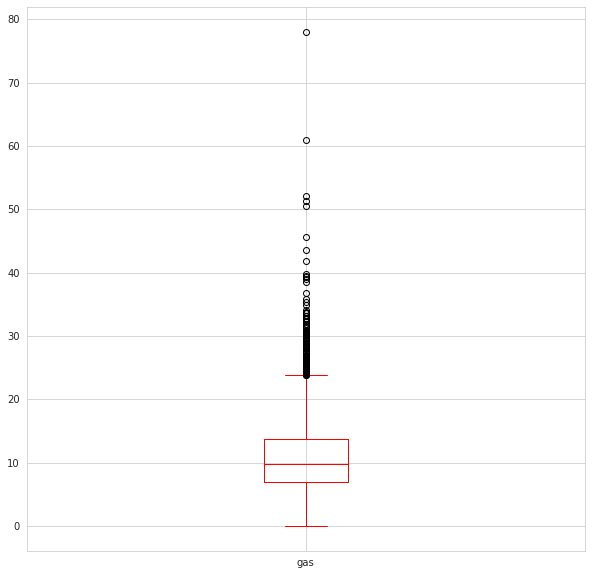

In [34]:
# посмотроим ящик с усами, чтобы посмотреть на выбивающиеся данные

display(data_gas['gas'].describe())

print('График распределения значений в столбце gas')

plt.figure(figsize=(10, 10))

sns.set_style('whitegrid')
data_gas.boxplot(column='gas', color='red')

plt.show()

Согласно данным из интернета, а именно (https://metallolome.ru/produvka-metalla-inertnymi-gazami/)

Расход инертного газа составляет обычно 0,1—3,0 м3/т стали. Безусловно в зависимости от задач технологического процесса данная величина может меняться, но она никак не может быть меньше 0,1 (тем более для всей партии). Поэтому посмотрим какое партий оказалось меньше 0,1.

Также значения свыше 50 кажутся странными. 

In [35]:
check_gas = data_gas.query('gas < 0.1')
check_gas['gas'].count()

2

In [36]:
check_gas2 = data_gas.query('gas >= 50')
check_gas2['gas'].count()

5

In [37]:
# избавимся от выбивающихся значений

data_gas = data_gas.drop(data_gas[data_gas.gas < 0.1].index)
data_gas = data_gas.drop(data_gas[data_gas.gas >= 50].index)                         

**Краткий вывод**

Все пункты по плану предобработки были выполнены. Таблица изначально была сформирована по номеру партии.

## Результаты измерения температуры

In [38]:
# сразу же переименуем столбцы

data_temp = data_temp.rename(columns = {'Время замера':'time_stamp', 'Температура':'temp'})
data_temp.head(3)

,key,time_stamp,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0


In [39]:
# посмотрим на кол-во замеров для каждой партии

count_batch = data_temp['key'].value_counts()
print(count_batch)

46      16
1214    16
44      16
1513    16
2108    15
        ..
1160     2
982      2
2456     2
195      1
279      1
Name: key, Length: 3216, dtype: int64


In [40]:
# посмотрим на количество пропусков

data_temp['temp'].isna().sum()

2901

In [41]:
# избавимся от пропусков

data_temp = data_temp.dropna(subset=['temp'])

In [42]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         13006 non-null  int64  
 1   time_stamp  13006 non-null  object 
 2   temp        13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.4+ KB


Text(0.5, 6.79999999999999, 'Количество замеров')

<Figure size 720x432 with 0 Axes>

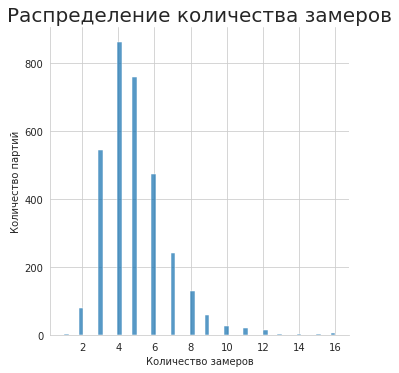

In [43]:
# посмотрим на график количества измерений

plt.figure(figsize=(10, 6))
sns.displot(count_batch)

plt.title(label='Распределение количества замеров', fontsize=20)
plt.ylabel('Количество партий')
plt.xlabel('Количество замеров')

In [44]:
# соотнесем время замера и температуру по партиям

last_temp = pd.DataFrame()
first_temp = pd.DataFrame()
unique_key = data_temp['key'].unique()

for key in unique_key:
    last_temp = last_temp.append(data_temp.loc[data_temp['key'] == key].tail(1), ignore_index = True)
    first_temp = first_temp.append(data_temp.loc[data_temp['key'] == key].head(1), ignore_index = True)
    
full_temp = last_temp.merge(first_temp,  how = 'inner', on = 'key')

full_temp.head(5)

,key,time_stamp_x,temp_x,time_stamp_y,temp_y
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0


In [45]:
count_batch2 = pd.DataFrame(data_temp['key'].value_counts()).sort_index().reset_index()

full_temp['count_bath'] = count_batch2['key']
full_temp = full_temp.drop(['time_stamp_x', 'time_stamp_y'], axis = 1)

full_temp.columns = ['key', 'end_temp', 'start_temp', 'count_batch']

full_temp.head(5)

,key,end_temp,start_temp,count_batch
0,1,1613.0,1571.0,5
1,2,1602.0,1581.0,6
2,3,1599.0,1596.0,5
3,4,1625.0,1601.0,3
4,5,1602.0,1576.0,2


In [46]:
# проверим кол-во единичных замеров 

full_temp_check = full_temp.query('count_batch < 2')
full_temp_check['count_batch'].count()

741

In [47]:
# удалим эти замеры

full_temp = full_temp.drop(full_temp[full_temp.count_batch < 2].index)

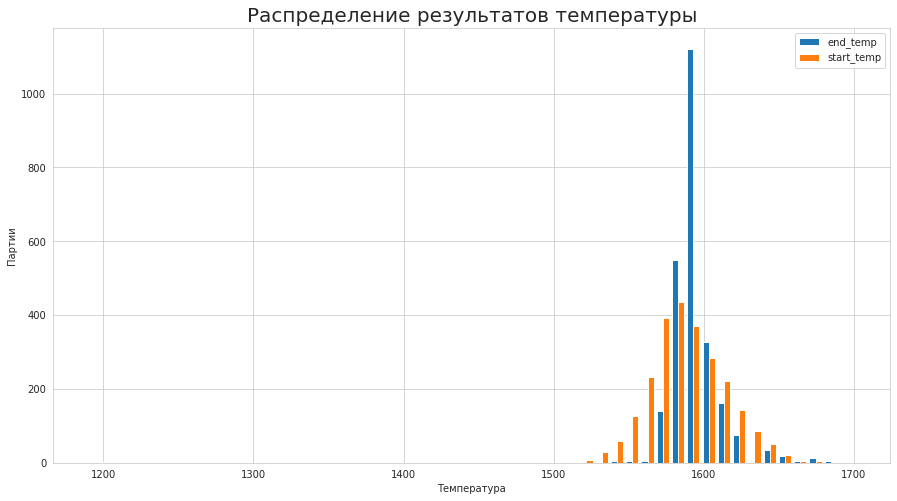

In [48]:
# посмотрим на распределение температуры в зависимости от времени замера

x = full_temp['end_temp']
y = full_temp['start_temp']

plt.figure(figsize=(15, 8))
plt.title(label='Распределение результатов температуры', fontsize=20)
plt.ylabel('Партии')
plt.xlabel('Температура')

plt.hist([x, y], bins=50, label=['end_temp', 'start_temp'])
pyplot.legend(loc='upper right')
pyplot.show()

График выглядит вполне нормально, однако слишком большой выброс конечной температуры в районе 1600 градусов выглядит немного странно. По информации от заказчика все данные по температуре необходимо оставить.

In [49]:
full_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2475 non-null   int64  
 1   end_temp     2475 non-null   float64
 2   start_temp   2475 non-null   float64
 3   count_batch  2475 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 96.7 KB


**Краткий вывод:**

Все пункты по плану предобработки были выполнены. В результате получили таблицу с сгруппированными по номеру партии данными. Дополнительно удалили данные, которые не состыковываются с таблицей по электродам.

## Объединение таблиц

In [50]:
final_data = (data_arc_new.merge(data_bulk, how = 'inner', on = 'key')
                 .merge(data_wire, how = 'inner', on = 'key')
                 .merge(data_gas, how = 'inner', on = 'key')
                 .merge(full_temp, how = 'inner', on = 'key'))

#final_data.set_index('key', inplace=True)

display(final_data.head(10))

,key,count_heat,sum_heat_sec,full_power,work,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,gas,end_temp,start_temp,count_batch
0,1,5,1098,5.826395,6397.381637,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986,1613.0,1571.0,5
1,2,4,811,3.649216,2959.514496,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561,1602.0,1581.0,6
2,3,5,655,2.989534,1958.144876,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793,1599.0,1596.0,5
3,4,4,741,3.814962,2826.887120,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219,1625.0,1601.0,3
4,5,4,869,4.035758,3507.073549,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692,1602.0,1576.0,2
5,6,4,952,4.786837,4557.068653,0.0,0.0,0.0,117.0,0.0,...,0.0,0.0,0.0,0.0,0.0,108.224477,11.273392,1596.0,1543.0,5
6,7,4,673,2.987777,2010.774053,0.0,0.0,0.0,117.0,0.0,...,0.0,0.0,0.0,0.0,0.0,98.061600,9.836267,1599.0,1586.0,5
7,8,4,913,4.627389,4224.805757,0.0,0.0,0.0,99.0,0.0,...,0.0,0.0,0.0,0.0,0.0,155.282394,15.171553,1598.0,1577.0,4
8,9,5,625,2.555348,1597.092768,0.0,0.0,0.0,117.0,0.0,...,0.0,0.0,0.0,0.0,0.0,122.536960,8.216623,1592.0,1587.0,5
9,10,6,825,3.851739,3177.684917,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,93.620796,6.529891,1593.0,1574.0,8


In [51]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 0 to 2322
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2323 non-null   int64  
 1   count_heat    2323 non-null   int64  
 2   sum_heat_sec  2323 non-null   int64  
 3   full_power    2323 non-null   float64
 4   work          2323 non-null   float64
 5   Bulk 1        2323 non-null   float64
 6   Bulk 2        2323 non-null   float64
 7   Bulk 3        2323 non-null   float64
 8   Bulk 4        2323 non-null   float64
 9   Bulk 5        2323 non-null   float64
 10  Bulk 6        2323 non-null   float64
 11  Bulk 7        2323 non-null   float64
 12  Bulk 9        2323 non-null   float64
 13  Bulk 10       2323 non-null   float64
 14  Bulk 11       2323 non-null   float64
 15  Bulk 12       2323 non-null   float64
 16  Bulk 13       2323 non-null   float64
 17  Bulk 14       2323 non-null   float64
 18  Bulk 15       2323 non-null 

In [52]:
final_data.duplicated().sum()

0

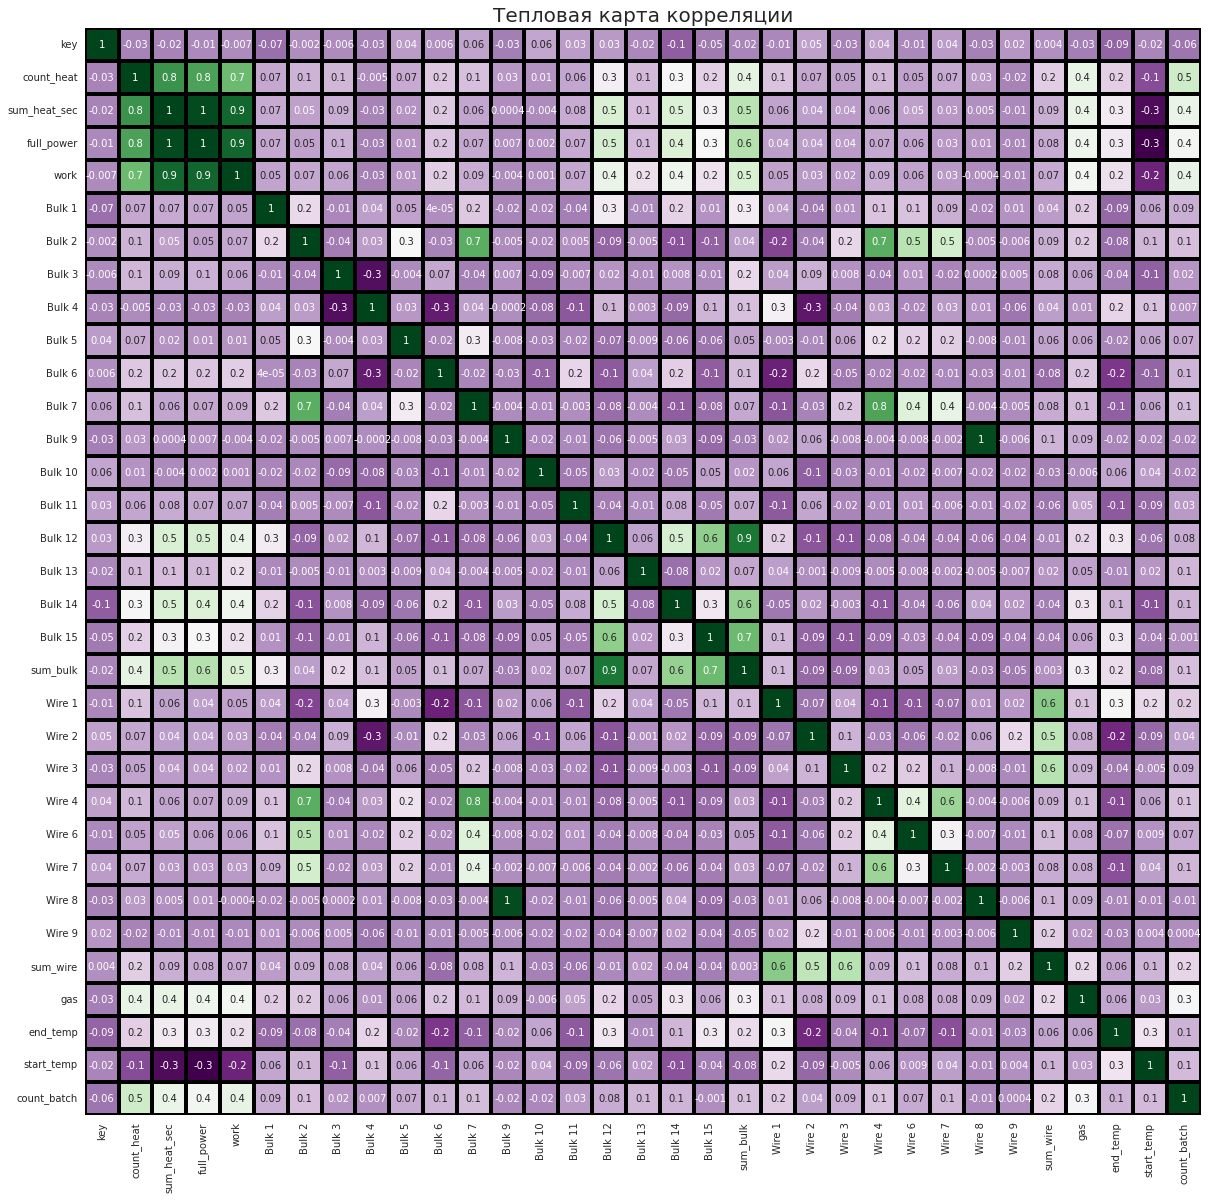

In [53]:
# проверим данные на мультиколлинеарность

fig, ax = plt.subplots(figsize=(20,20))
plt.title(label='Тепловая карта корреляции', fontsize=20)

sns.heatmap(final_data.corr(), annot=True, fmt='.1g', cmap='PRGn', linewidths=3, linecolor='black', cbar=False)

In [54]:
# выведем пары признаков с высокой корреляцией

heatmap_corr = final_data.corr().unstack().sort_values(ascending=False)
display(heatmap_corr[27:57])

gas           gas             1.000000
end_temp      end_temp        1.000000
start_temp    start_temp      1.000000
sum_heat_sec  sum_heat_sec    1.000000
Bulk 13       Bulk 13         1.000000
count_batch   count_batch     1.000000
full_power    sum_heat_sec    0.982582
sum_heat_sec  full_power      0.982582
Bulk 9        Wire 8          0.973817
Wire 8        Bulk 9          0.973817
work          full_power      0.912441
full_power    work            0.912441
work          sum_heat_sec    0.907430
sum_heat_sec  work            0.907430
Bulk 12       sum_bulk        0.864053
sum_bulk      Bulk 12         0.864053
sum_heat_sec  count_heat      0.796087
count_heat    sum_heat_sec    0.796087
              full_power      0.762961
full_power    count_heat      0.762961
Bulk 7        Wire 4          0.753913
Wire 4        Bulk 7          0.753913
Bulk 7        Bulk 2          0.731931
Bulk 2        Bulk 7          0.731931
              Wire 4          0.728841
Wire 4        Bulk 2     

In [55]:
# я бы удалила следующие столбцы, т.к. они сильно коррелируют с другими признаками

final_data_clean = final_data.drop(['sum_heat_sec'], axis=1)

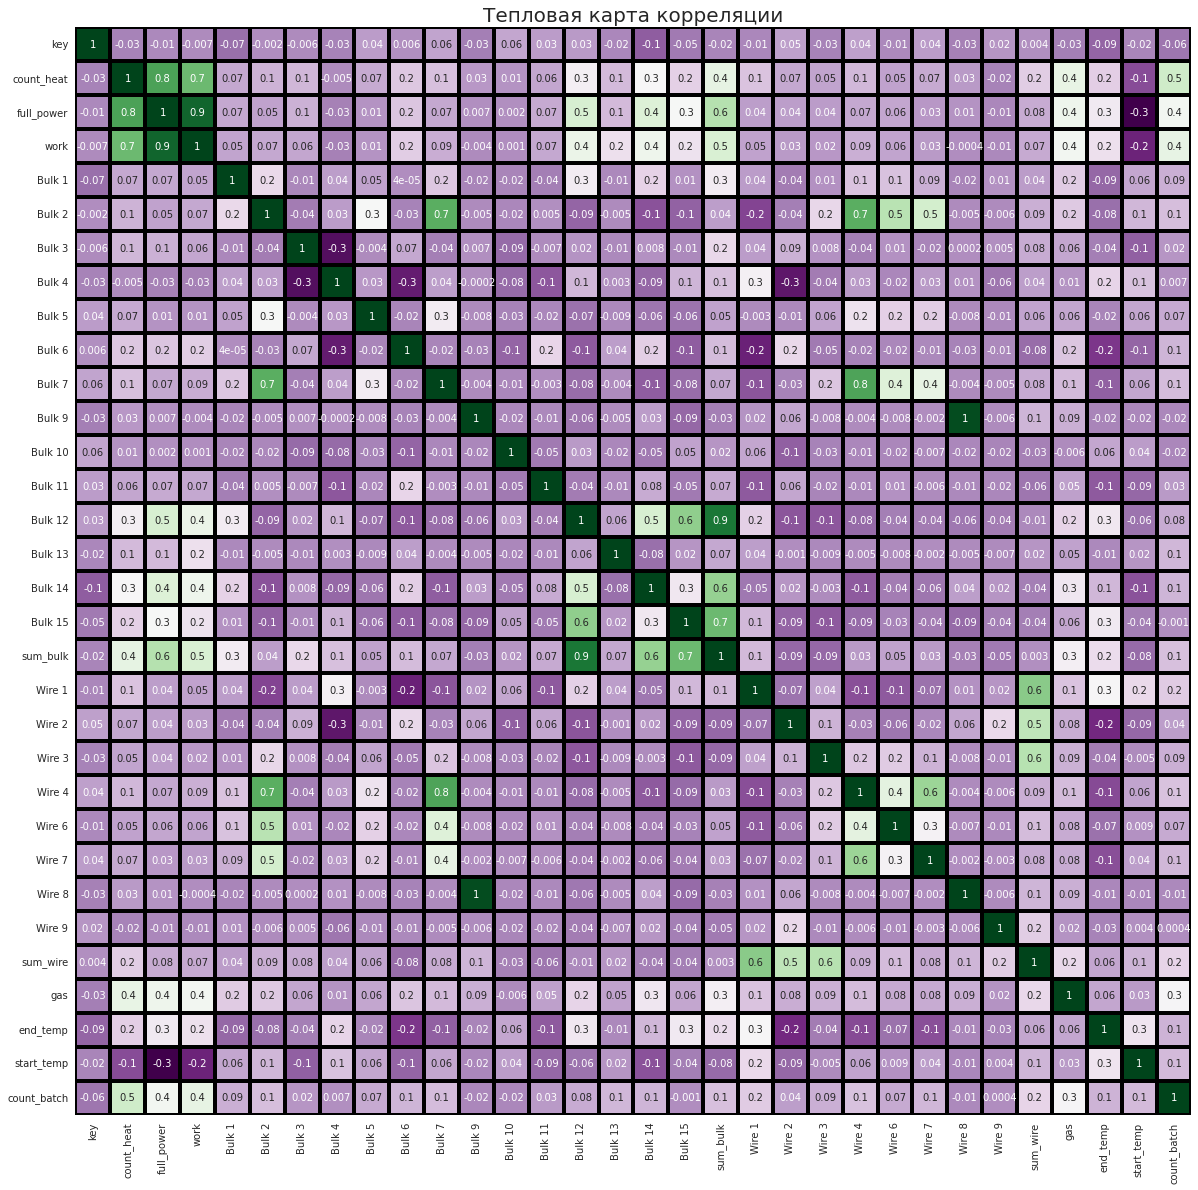

In [56]:
fig, ax = plt.subplots(figsize=(20,20))
plt.title(label='Тепловая карта корреляции', fontsize=20)

sns.heatmap(final_data_clean.corr(), annot=True, fmt='.1g', cmap='PRGn', linewidths=3, linecolor='black', cbar=False)

**Краткий вывод**

- Была проведена предобработка данных согласно плану, в ходе которой пришлось удалить много данных.
- Были созданы дополнительные признаки.
- Данные были проверены на мультиколлинеарность. Остались некоторые значения, которые имеют корреляцию выше среднего. На данный момент мы их оставили.

## Подготовка признаков

In [57]:
# разделим данные на обучающую и тестовую выборки

target = final_data_clean['end_temp']
features = final_data_clean.drop(['end_temp'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [58]:
print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(1742, 31) (581, 31)
(1742,) (581,)


In [59]:
# промасштабируем признаки

numeric = features.columns

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Краткий вывод**

Подготовка признаков была выполнена. Было принято решение промасштабировать данные.

## Вывод по разделу

- Данные были тщательно обработаны и подготовлены для дальнейшей работы.
- В ходе обработки данных было выявлено, что на производстве очевидно есть сбои в передаче данных. Так, например, данные оказались неполными в таблице с измерением температур - были пропущены данные по температурам или времени замера, было достаточно много единичных замеров по партиям, что также явно является ошибкой.
- Также в таблицах о падаче сыпучих и проволочных материалов присутствует очень много нулевых значений. Конечно, большинство таких значений обусловлено технологическим процессом, но опять-таки здесь тоже наверняка присутствует проблема передачи данных. Некоторые столбцы (Bulk 8 и Wire 5) оказались полностью пустыми.
- Таблицы с временем подачи сыпучих и проволочных материалов обработаны не были, так как полезной информации для обучения моделей они не несут.
- О данных по продувке стали газом тоже достаточно сложно судить, так как они даны в сумме по каждой партии. Без глубинного знания технологического процесса и с отсутствием отдельных данных по каждой итерации обдува достаточно сложно выявить аномалии. Однако некоторое значение слишком выбивающихся данных было удалено.
- По результатам объединения таблиц было удалено несколько столбцов, которые сильно коррелировали между собой.
- Было принято решение поделить данные в соотношении 70:30 на обучающую и тестовую выборку, так как обучение моделей будет проходить при помощи кросс-валидации.

# Обучение моделей

Было принято решение обучить следующие модели:

- Linear Regression
- CatBoost
- LGBMRegressor
- DecisionTree Regressor
- RandomForest Regressor

In [60]:
# для наглядности результатов сведем после обучения полученные метрики в таблицу

def metrics(result_train, model, data):
    data.loc[model, 'MAE_train'] = result_train
    return data

In [61]:
# таблица для сравнения результатов обучения моделей

compare_models = pd.DataFrame(columns=['MAE_train'])

## Создание константной модели

In [62]:
%%time

dummy = DummyRegressor(strategy="mean")
dummy_model = dummy.fit(features_train, target_train)

dummy_pred_test = dummy_model.predict(features_test)

dummy_mae_test = mean_absolute_error(target_test, dummy_pred_test)

print('MAE для константной модели на тестовой выборке:{:.2f}'.format(dummy_mae_test))

MAE для константной модели на тестовой выборке:8.43
CPU times: user 5.18 ms, sys: 0 ns, total: 5.18 ms
Wall time: 5.2 ms


## Linear Regression

In [63]:
%%time

# найдем лучшее значение МАЕ с помощью кросс-валидации

model_lr = LinearRegression()
cross_v_lr = cross_val_score(model_lr, features_train, target_train, cv=3, scoring='neg_mean_absolute_error')

mae_lr = np.mean(np.abs(cross_v_lr))

print('Среднее значение MAE на кросс-валидации: {:.2f}'.format(mae_lr))

Среднее значение MAE на кросс-валидации: 6.46
CPU times: user 37.7 ms, sys: 24.4 ms, total: 62 ms
Wall time: 54.6 ms


## CatBoost

In [64]:
%%time

#подберем наилучшие параметры с помощью кросс-валидации

model_cb = CatBoostRegressor(random_state=42, verbose=False)
params_cb = {'max_depth': [2, 4, 6], 'learning_rate': [0.03, 0.1], 'iterations': [50, 100, 200, 500]}

random_cb = GridSearchCV(model_cb, params_cb, scoring='neg_mean_absolute_error', cv=3)
random_cb.fit(features_train, target_train)

mae_cb = np.mean(np.abs(random_cb.best_score_))

print('Лучшие гиперпараметры для модели:', random_cb.best_params_) 
print('Среднее значение MAE на кросс-валидации: {:.2f}'.format(mae_cb))

Лучшие гиперпараметры для модели: {'iterations': 500, 'learning_rate': 0.03, 'max_depth': 6}
Среднее значение MAE на кросс-валидации: 5.90
CPU times: user 1min 13s, sys: 3.75 s, total: 1min 16s
Wall time: 41.9 s


## LGBMRegressor

In [65]:
%%time

#подберем наилучшие параметры с помощью кросс-валидации

model_lgmr = LGBMRegressor(random_state=42)
params_lgmr = {'max_depth': [2, 4, 6], 'learning_rate': [0.03, 0.1], 'n_estimators': [50, 100, 200, 500, 1000]}

random_lgmr = GridSearchCV(model_lgmr, params_lgmr, scoring='neg_mean_absolute_error', cv=3)
random_lgmr.fit(features_train, target_train)

mae_lgbm = np.mean(np.abs(random_lgmr.best_score_))

print('Лучшие гиперпараметры для модели:', random_lgmr.best_params_) 
print('Среднее значение MAE на кросс-валидации: {:.2f}'.format(mae_lgbm))

Лучшие гиперпараметры для модели: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
Среднее значение MAE на кросс-валидации: 6.02
CPU times: user 42.8 s, sys: 1.07 s, total: 43.8 s
Wall time: 22.4 s


## DecisionTreeRegressor

In [66]:
%%time

#подберем наилучшие параметры с помощью кросс-валидации

model_dt = DecisionTreeRegressor(random_state=12345)
params_dt = {'max_depth': [2, 4, 10, 30]}

random_dt = GridSearchCV(model_dt, params_dt, scoring='neg_mean_absolute_error', cv=3)
random_dt.fit(features_train, target_train)

mae_dt = np.mean(np.abs(random_dt.best_score_))

print('Лучшие гиперпараметры для модели:', random_dt.best_params_) 
print('Среднее значение MAE на кросс-валидации: {:.2f}'.format(mae_dt))

Лучшие гиперпараметры для модели: {'max_depth': 4}
Среднее значение MAE на кросс-валидации: 6.94
CPU times: user 200 ms, sys: 1.94 ms, total: 202 ms
Wall time: 200 ms


## RandomForestRegressor

In [67]:
%%time

#подберем наилучшие параметры с помощью кросс-валидации

model_rf = RandomForestRegressor(random_state=12345)
params_rf = {'n_estimators': [100, 300, 500], 'max_depth': [2, 4, 6], 'min_samples_split': [2, 5, 8]}

random_rf = GridSearchCV(model_rf, params_rf, scoring='neg_mean_absolute_error', cv=3)
random_rf.fit(features_train, target_train)

mae_rf = np.mean(np.abs(random_rf.best_score_))

print('Лучшие гиперпараметры для модели:', random_rf.best_params_) 
print('Среднее значение MAE на кросс-валидации: {:.2f}'.format(mae_rf))

Лучшие гиперпараметры для модели: {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 500}
Среднее значение MAE на кросс-валидации: 6.28
CPU times: user 1min 59s, sys: 386 ms, total: 2min
Wall time: 2min 1s


In [68]:
metrics(dummy_mae_test, 'DummyClassifier', compare_models)
metrics("{:.2f}".format(mae_lr), 'LinearRegression', compare_models)
metrics("{:.2f}".format(mae_cb), 'CatBoostRegressor', compare_models)
metrics("{:.2f}".format(mae_lgbm), 'LGBMRegressor', compare_models)
metrics("{:.2f}".format(mae_dt), 'DecisionTreeRegressor', compare_models)
metrics("{:.2f}".format(mae_rf), 'RandomForestRegressor', compare_models)

,MAE_train
DummyClassifier,8.429969
LinearRegression,6.46
CatBoostRegressor,5.90
LGBMRegressor,6.02
DecisionTreeRegressor,6.94
RandomForestRegressor,6.28


## Вывод по разделу

- Подбор гипперпараметров был реализован с помощью cross_val_score и GridSearchCV. GridSearchCV был выбран из-за его скорости подбора. Безусловно, на мой взгляд RandomSearch был бы эффективнее. Это интересно проверить и сравнить результаты. 
- Наилучший результат на обучающей выборке показала модель CatBoost. Ее мы и будем тестировать.
- LGBMRegressor также на фоне результатов остальных моделей показал хороший результат.


# Тестирование моделей

## Константная модель

In [69]:
%%time

dummy_test = DummyRegressor(strategy="mean")
dummy_model_test = dummy_test.fit(features_train, target_train)

dummy_pred_test = dummy_model_test.predict(features_test)

dummy_mae_test = mean_absolute_error(target_test, dummy_pred_test)

print('MAE для константной модели на тестовой выборке:{:.2f}'.format(dummy_mae_test))

MAE для константной модели на тестовой выборке:8.43
CPU times: user 3.27 ms, sys: 34 µs, total: 3.31 ms
Wall time: 2.61 ms


## CatBoost

In [70]:
%%time

model_cb_test = CatBoostRegressor(iterations=500, depth = 6, learning_rate = 0.03, random_state=42, verbose=False)

model_cb_test.fit(features_train, target_train)

model_cb_test_pred = model_cb_test.predict(features_test)

mae_cb_test = mean_absolute_error(target_test, model_cb_test_pred)

print('MAE на тестовой выборке: {:.2f}'.format(mae_cb_test))

MAE на тестовой выборке: 5.98
CPU times: user 4.41 s, sys: 211 ms, total: 4.62 s
Wall time: 2.47 s


In [71]:
model_cb_test.feature_importances_

array([3.94509949e+00, 2.02591912e+00, 1.40321845e+01, 1.25858266e+01,
       2.12648293e+00, 2.36233148e-01, 9.75007508e-01, 1.33641789e+00,
       1.28061043e-01, 6.48113259e+00, 3.04230756e-01, 4.86317891e-04,
       2.27522005e-01, 4.81933385e-01, 2.69896255e+00, 9.52572367e-02,
       2.93375394e+00, 3.78557505e+00, 3.00901307e+00, 5.14091047e+00,
       3.79559423e+00, 3.56719763e-01, 6.26304017e-01, 1.67543597e-01,
       3.38877870e-01, 1.38674806e-05, 3.13499774e-03, 2.09550299e+00,
       2.55000185e+00, 2.50504337e+01, 2.46586353e+00])

Text(0.5, 0, 'CatBoost: используемые признаки и их влияние на модель')

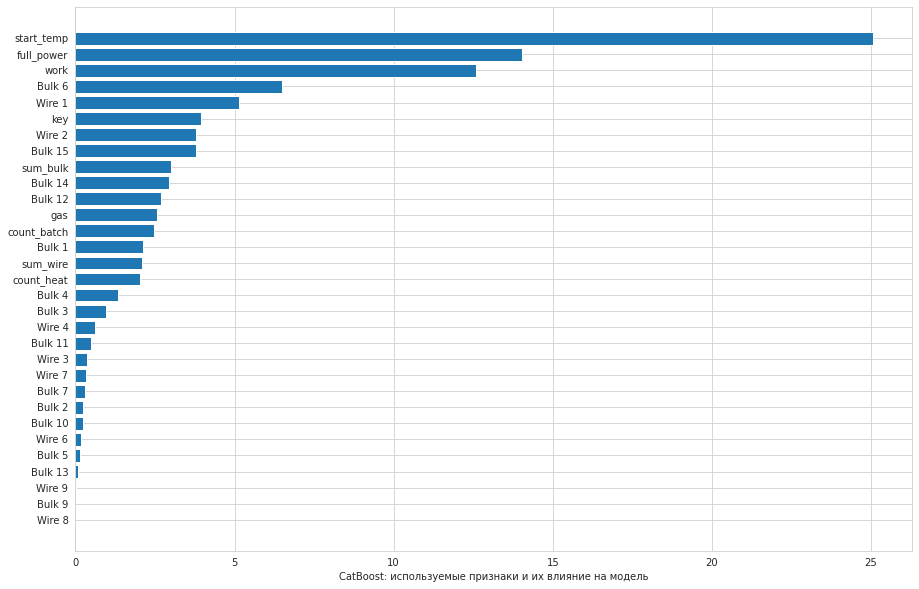

In [72]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = model_cb_test.feature_importances_.argsort()
plt.barh(features_test.columns.values[sorted_idx], model_cb_test.feature_importances_[sorted_idx])
plt.xlabel("CatBoost: используемые признаки и их влияние на модель")

# Вывод по работе

Было проведено исследование данных для оптимизации производственных расходов. Цель исследования - построить модель, которая сможет предсказать температуру стали. Нам были предоставленны данные с каждого технологического этапа обработки стали.
Заказчик дал следующие пороги метрики (необходимо оценить как модель ошибается в абсолютном выражении)  для оценки модели:

<br> **MAE** > 8.7 — 0 sp
<br> 7.6 < **MAE** ≤ 8.7 — 4 sp
<br> 6.8 < **MAE** ≤ 7.6 — 4.5 sp
<br> 6.3 < **MAE** ≤ 6.8 — 5 sp
<br> 6.0 < **MAE** ≤ 6.3 — 5.5 sp
<br> **MAE** ≤ 6.0 — 6 sp
<br>
<br>

Задача была выполнена успешно. В ходе тестирования модели CatBoost, удалось достичь результата 5.98. Поэтому рекомендуем заказчику эту модель к использованию.


---


**Краткие комментарии по работе**

- Заказчику необходимо обратить внимание на процесс передачи данных на производстве. Много данных утеряно, выборку пришлось также исказить и сократить.
- Если есть данные по каждой итерации продувкой газа, то это помогло бы более тщательно предобработать данные, так как могли бы быть выявлены дополнительные аномалии.
- При обучении модели CatBoost в следующий раз можно попробовать перебор параметров с помощью RandomSearchCV. Могу предположить, что результаты могут улучшиться.


---


**Используемые признаки**
<br>_Данные указаны в порядке значимости (от большего к меньшему)_

Из таблицы с информацией об электродах:
- full_power (полная мощность)
- work (работа)
- count_heat (количество итераций нагрева электродами)

Из таблицы о подаче сыпучих материалов:
- Bulk 6
- Bulk 15
- sum_bulk (общее кол-во добавленных материалов)
- Bulk 14
- Bulk 12
- Bulk 1
- Bulk 4
- Bulk 3
- Bulk 7
- Bulk 2
- Bulk 5
- Bulk 13
- Bulk 9

Из таблицы о подаче проволочных материалов:
- Wire 1
- Wire 2
- sum_wire (общее кол-во добавленных материалов)
- Wire 4
- Wire 3
- Wire 7
- Wire 6
- Wire 9
- Wire 8

Из таблицы о продувке газом:
- gas

Из таблицы об измерении температуры:
- start_temp (начальная температура)
- count_batch (кол-во замеров температуры)


---

**Список выполненных работ**



1.   Исследовательский анализ данных
2.   Предобработка данных
3.   Определение целевого признака и подготовка остальных признаков
4.   Обучение моделей
5.   Тестирование модели, показавшей лучшие результаты на обучающей выборке

